# DPLE: ENSO Check 
 - Check Nino3.4 prediction
 - data I/O functions based on template from daniel kennedy (djk2120@ucar.edu): https://github.com/djk2120/cesm-lens

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [23]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
cluster

### Data I/O functions:
 - Run each of these cells, then proceed to Main Processing
 - Note that these functions are currently hard-wired to retrieve ocean monthly data

In [5]:
def file_dict(filetempl,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given experiment, field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    filetemp = filetempl.replace('MM',monstr).replace('EEE',memstr)

    #find all the relevant files
    files = glob.glob(filetemp)
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split('.pop.h.')[0]
        y0 = int(ystr[-11:-7])
        filepaths[y0]=file
        
    return filepaths

In [6]:
def nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a nested list of files for these start years and ensemble members'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=start_year, dim1=ens
    ix = np.zeros(yrs.shape)+1
    
    for yy,i in zip(yrs,range(len(yrs))):
        ffs = []  # a list of files for this yy
        file0 = ''
        first = True
        for ee in ens:
            filepaths = file_dict(filetemplate,ee,stmon)
            #append file if it is new
            if yy in filepaths.keys():
                file = filepaths[yy]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,yrs[ix==1]

In [7]:
## NOTE
## Regulate dask array size using this proprocess function.
## Set appropriately based on analysis to come.
## E.g., currently set to extract POP surface layer and 24 months of data
def preprocess(ds):
    return ds.isel(z_t=0).isel(time=slice(0,24))

def open_members(in_obj):
    ffs = in_obj[0]  #unwrap the list
    field = in_obj[1]
    ens = in_obj[2]
    lm = in_obj[3]
    chunks = in_obj[4]
    
    d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,concat_dim='M',data_vars=[field],\
                           chunks=chunks,compat='override', coords='minimal', preprocess=preprocess)
    #added compat=override, coords=minimal here. Assumes that all hindcasts have same dims/coords. Seems a little dangerous
    #but REALLY speeds things up. And we know that the coords are the same for all of SMYLE anyway.

    # quick fix to adjust time vector for monthly data  
    nmonths = len(d0.time)
    yr0 = d0['time.year'][0].values
    d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    d0 = d0.assign_coords(M=("M",ens))
    d0 = d0.assign_coords(L=("time",lm))
    d0 = d0.swap_dims({'time': 'L'})
    d0 = d0.reset_coords(["time"])
    
    return d0

In [8]:
def get_monthly_data(filetemplate,ens,leads,field,firstyear,lastyear,stmon,chunks={}):
    ''' returns dask array containing the requested hindcast ensemble '''

    ds = xr.Dataset()    #instantiate Dataset
    lm = np.array(leads)+1
    files,yrs = nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon)
    ens = np.array(ens)+1
    
    # all members should have the same number of files, otherwise abort
    nfs = np.array([len(ffs) for ffs in files])
    if np.sum(nfs==nfs[0])==len(nfs):
        complete_set=True   # same number of files
    else:
        raise ValueError('ERROR: Incomplete set of files')
        
    if complete_set: #read all data using map/gather
        dsets = []
        in_obj = [[ffs, field, ens, lm, chunks] for ffs in files]
        dsets = client.map(open_members, in_obj)
        dsets = client.gather(dsets)
        tmp = xr.concat(dsets,dim='Y',data_vars=[field,'time','time_bound'], coords='minimal', compat='override')
        #potentially dangerous compat/coords option - xarray is NOT checking that the coordinates 
        #are the same across all files - pulling values of shared coords from the first file only
        #speeds up read-in time by ~1/3
        tmp = tmp.assign_coords(Y=("Y",yrs))

    ds[field] = tmp[field]
    ds['time'] = tmp['time']
    ds['time_bound'] = tmp['time_bound']
    ds['TAREA'] = tmp['TAREA']
    ds['UAREA'] = tmp['UAREA']

    return ds

# Main Processing

### Read in POP monthly field
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [9]:
%%time
# DPLE data
# process all 40 ensemble members, first 24 months, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetemplate = datadir+field+'/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(40) 
#leadtimes = range(122)
leadtimes = range(24)
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
dple_temp = get_monthly_data(filetemplate,ens,leadtimes,field,firstyear,lastyear,startmonth)
dple_temp.nbytes/1e9 #GB

CPU times: user 9.13 s, sys: 2.52 s, total: 11.6 s
Wall time: 19.7 s


22.655168388

In [10]:
# Load this in memory to speed up later computations
dple_temp = dple_temp.persist()

### Compute Nino3.4 Index

In [11]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [13]:
POPg16_nino34_area = POP_regional_areawgt(dple_temp,[-170.,-120.],[-5.,5])

Here, perform actual computation, returning xarray:

In [14]:
%%time
dple_nino34 = dple_temp.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
dple_time_bound = dple_temp.time_bound.load()

CPU times: user 7.46 s, sys: 116 ms, total: 7.58 s
Wall time: 7.72 s


In [15]:
# Observed Nino3.4 (NOAA ERSSTv5)
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/SST/NOAA_ERSSTv5/ersst.v5.188001-202012.gx1v6.nc',decode_times=False)
obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_obs['time'] = obs_time_vals
obs_nino34 = ds_obs.sst.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()

### Generate Time Series Plot
- For some reason, I can't get `errorbar` or `scatter` plot methods to handle the cftime.DatetimeNoLeap time values. `plot` can handle it. 
The error message reports it needs cftime.datetime objects, but isinstance(smyletime.values[0],cftime.datetime) returns True.

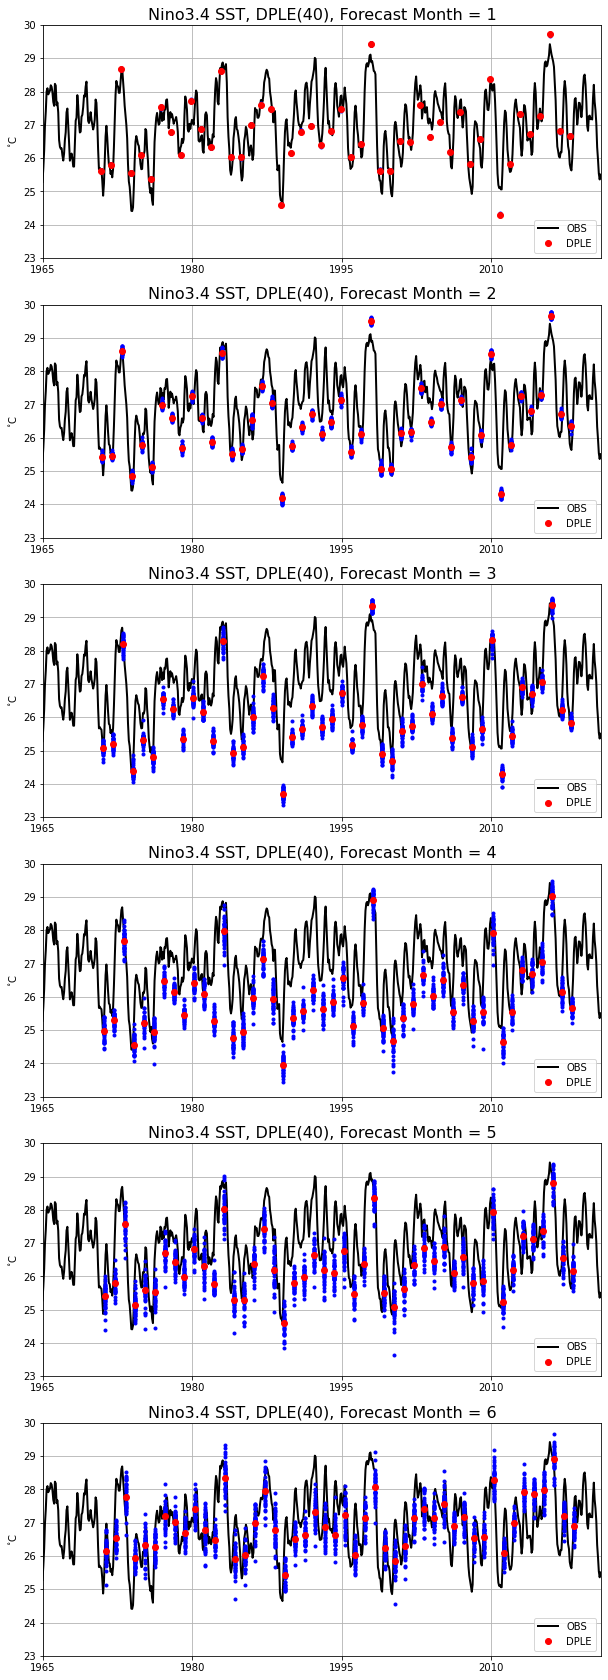

In [16]:
nlead = 6
fig = plt.figure(figsize=(10, nlead*5))
nrow = nlead
ncol = 1

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

for i in range(nlead):
    thislead = i+1    
    dpletime = dple_time_bound.sel(L=thislead).mean('d2')
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(dpletime,dple_nino34.sel(L=thislead),'.',color='b')
    ax.plot(dpletime,dple_nino34.sel(L=thislead).mean('M'),'o',color='r',label='DPLE')
    ax.grid()
    ax.set_title('Nino3.4 SST, DPLE(40), Forecast Month = {}'.format(thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')

### Generate Correlation Skill Plot

In [17]:
%%time
# Correlation as a function of forecast month:
dple_ccoef   = xr.DataArray(np.zeros([dple_nino34.sizes['L']]), dims=['L'], coords={'L':dple_nino34['L']})
for i in range(dple_nino34.sizes['L']):
    leadindex = dple_nino34['L'].values[i]
    dpletime = dple_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    dple_em = dple_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=dpletime,method='nearest')
    dple_em = dple_em.assign_coords(time=("time",obs.time))
    dple_ccoef.values[i] = xr.corr(dple_em, obs)

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 162 ms


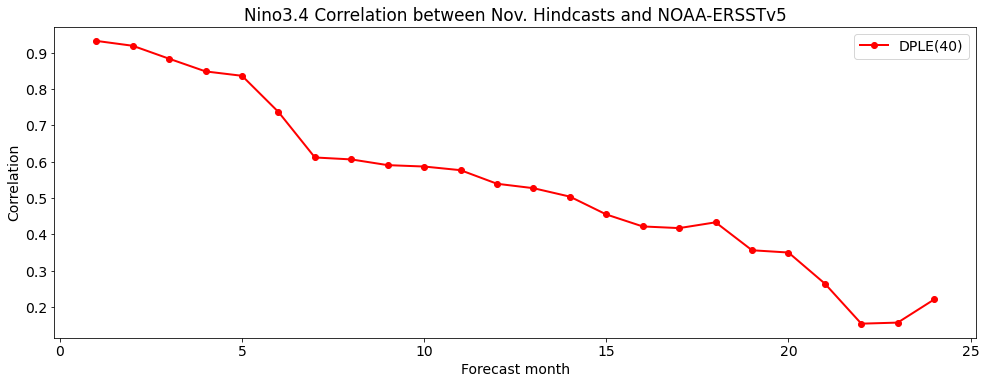

In [18]:
# plot correlation
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'
ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 Correlation between Nov. Hindcasts and NOAA-ERSSTv5')
ax.plot(dple_ccoef.L,dple_ccoef,color='r', marker='o',linewidth=2,label='DPLE(40)')
ax.legend(loc='upper right')

### Generate RMSE Skill Plot

In [19]:
%%time
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# RMSE as a function of forecast month:
dple_rmse   = xr.DataArray(np.zeros([dple_nino34.sizes['L']]), dims=['L'], coords={'L':dple_nino34['L']})
for i in range(dple_nino34.sizes['L']):
    leadindex = dple_nino34['L'].values[i]
    dpletime = dple_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    dple_em = dple_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=dpletime,method='nearest')
    dple_em = dple_em.assign_coords(time=("time",obs.time))
    dple_rmse.values[i] = rmse(dple_em, obs)

CPU times: user 104 ms, sys: 952 µs, total: 105 ms
Wall time: 110 ms


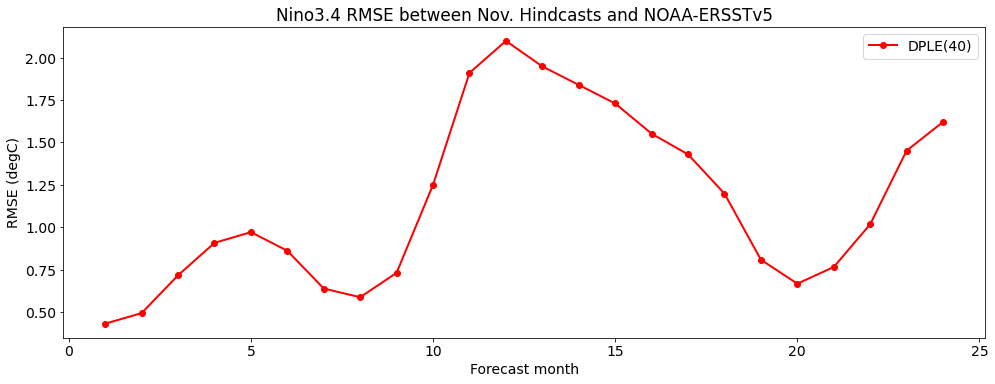

In [20]:
# plot RMSE
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'
ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('RMSE (degC)', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 RMSE between Nov. Hindcasts and NOAA-ERSSTv5')
ax.plot(dple_rmse.L,dple_rmse,color='r', marker='o',linewidth=2,label='DPLE(40)')
ax.legend(loc='upper right')

### Generate Mean Bias (Drift) Plot

In [21]:
%%time
def bias(predictions, targets):
    return ((predictions - targets).mean())

# Bias as a function of forecast month:
dple_bias   = xr.DataArray(np.zeros([dple_nino34.sizes['L']]), dims=['L'], coords={'L':dple_nino34['L']})
for i in range(dple_nino34.sizes['L']):
    leadindex = dple_nino34['L'].values[i]
    dpletime = dple_time_bound.sel(L=leadindex).mean('d2').rename({'Y':'time'})
    dple_em = dple_nino34.sel(L=leadindex).mean('M').rename({'Y':'time'})
    obs = obs_nino34.sel(time=dpletime,method='nearest')
    dple_em = dple_em.assign_coords(time=("time",obs.time))
    dple_bias.values[i] = bias(dple_em, obs)

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 105 ms


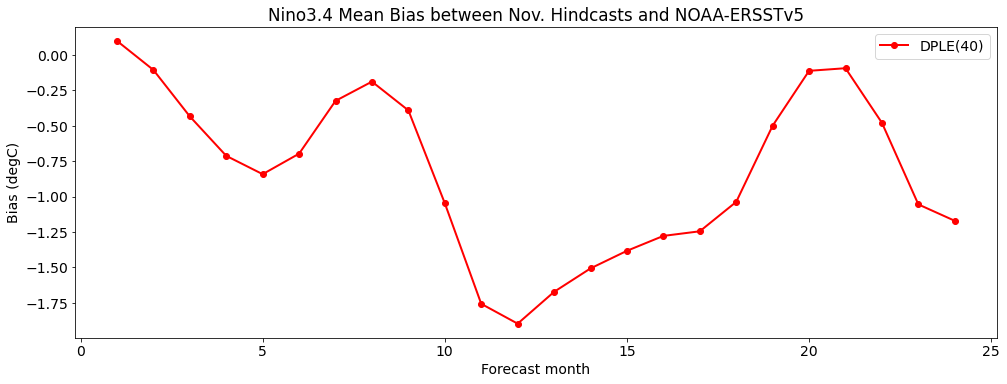

In [22]:
# plot Bias
fig = plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = '14'
ax = fig.add_axes([0.1,0.7,0.8,0.27])
ax.set_ylabel('Bias (degC)', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 Mean Bias between Nov. Hindcasts and NOAA-ERSSTv5')
ax.plot(dple_bias.L,dple_bias,color='r', marker='o',linewidth=2,label='DPLE(40)')
ax.legend(loc='upper right')